<font size=4><b>1. Libraries Importation:</b></font>


In [2]:
# External libraries
from quimb import *
import numpy as np
import numpy.linalg as LA
import random
import pandas as pd
import matplotlib.pyplot as plt
import warnings
 
# Qiskit libraries
from qiskit import IBMQ, assemble, transpile, Aer
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X, Y, CircuitStateFn, CircuitOp, SummedOp, PauliSumOp
from qiskit.opflow.expectations import PauliExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.opflow.state_fns import StateFn
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli
from qiskit.providers.aer import QasmSimulator
warnings.filterwarnings("ignore", category=DeprecationWarning)

<ipython-input-2-efec60be645a>:14: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, Z, X, Y, CircuitStateFn, CircuitOp, SummedOp, PauliSumOp


## <font size=4>1. `replace_char` Function</font>

The `replace_char` function replaces a character in a given string at a specific index with a new character. It serves as a utility function to assist in constructing specific quantum strings, like Pauli operators, during the simulation.

---

## <font size=4>2. `create_pauli_str` Function</font>

The `create_pauli_str` function generates Pauli operator strings (X, Y, Z) for a specific qubit index. Given a total number of qubits `N_qubit` and a qubit index `j`, it produces a set of Pauli strings with the operator acting on the j-th qubit.

---

## <font size=4>3. `calculate_expectation` Function</font>

The `calculate_expectation` function computes expectation values based on the results obtained from a Qiskit simulation. It interprets the result bitstrings, converting them to spin configurations, and then calculates the associated expectation values. Various types of computations, such as "polarization", "N_half", and "Cj", can be selected based on the `Type` parameter.

---

## <font size=4>4. `find_sampled_expectation` Function</font>

The `find_sampled_expectation` function computes expectation values for a specified quantum circuit `qc` and a quantum operator `op`. It initializes the circuit with a certain spin configuration, performs the circuit operation, and then measures the system. The obtained counts are used to compute the expectation values using the `calculate_expectation` function.



In [3]:
def replace_char(s, index, char):
    return s[:index] + char + s[index+1:]




def create_pauli_str(N_qubit,j):
    chars=["Z","X","Y"]
    STRs=[]
    for char in chars:
        Identity_str=("I"*N_qubit) 
        STR= replace_char(Identity_str,j,char)
        STR= replace_char(STR,j+1,char)
        STRs.append(STR)
    return STRs



def calculate_expectation(counts, num_shots, N_qubit=6, Type="polarization"):
    bitstrings = counts.keys()
    probs = np.array(list(counts.values()))
    
    spins = np.array([[int(char) for char in s] for s in bitstrings])
    spins[spins == 1] = -1
    spins[spins == 0] = 1
    
    expec_arr = (spins * probs[:, None]) / num_shots
    expec = expec_arr.sum(axis=0)  
    
    if Type == "polarization":    
        return expec
    elif Type == "N_half":
        spins = (spins + 1) / 2
        return np.sum((spins * probs[:, None]).sum(axis=0)[:N_qubit//2])
    elif Type == "Cj":
        Cs = []
        for k in range(N_qubit):
            corr_matrix = spins[:, 0][:, np.newaxis] * spins
            expec_arr_j = (corr_matrix * probs[:, None]).sum(axis=0) / num_shots
            C_j = expec_arr_j[0] * expec_arr_j[k] - expec[0] * expec[k]
            Cs.append(C_j)
        return Cs

    
def find_sampled_expectation(op, qc, N_qubit, initial_spin_config, Type="polarization"):
    
    qc_init = QuantumCircuit(N_qubit)
    if initial_spin_config == "domain_wall":
        qc_init.x(range(N_qubit//2,N_qubit))
    elif initial_spin_config == "neel":
        qc_init.x(range(0, N_qubit, 2))
    
    qc_2 = qc_init.compose(qc.copy())
    qc_2 = qc_2.compose(op.to_circuit_op().primitive)  # Updated this line
    qc_2.measure_all()
    
    num_shots = 8192
    simulator = Aer.get_backend('aer_simulator')
    transpiled = transpile(qc_2, simulator)  
    result = simulator.run(transpiled, shots=num_shots, optimization_level=3).result()
    counts = result.get_counts(transpiled)
    
    del qc_2
    return calculate_expectation(counts, num_shots=num_shots, N_qubit=N_qubit, Type=Type)


## <font size=4>1. `plot_expectation_exact_diagonalization` Function</font>

This function visualizes the time evolution of local magnetizations and spin-spin correlations for a quantum state, utilizing exact diagonalization. Within it, several nested helper functions assist in computing the relevant observables for each time step.

### <font size=4>1.1. Helper Function: `time_evolved_state(eigenvalues, eigenvectors, t)`</font>

Computes the state of the quantum system after a time evolution of duration \( $t$ \).

### <font size=4>1.2. Helper Function: `sigma_z_operator(j)`</font>

Constructs the \( $\sigma_z$ \) operator for the \( $j^{th}$ \) qubit, representing a measurement in the Z basis for that specific qubit.

### <font size=4>1.3. Helper Function: `spin_corr_operator(j, k)`</font>

Constructs the spin-spin correlation operator for the \( $j^{th}$ \) and \( $k^{th}$ \) qubits.

### <font size=4>1.4. Helper Function: `local_magnetization(j, evolved_state)`</font>

Computes the expectation value of the \( $\sigma_z$ \) operator, effectively giving the local magnetization for the \( $j^{th}$ \) qubit.

### <font size=4>1.5. Helper Function: `connected_spin_corr(j, k, evolved_state)`</font>

Computes the connected spin-spin correlation between the \( $j^{th}$ \) and \( $k^{th}$ \) qubits.


In [322]:
def plot_expectation_exact_diagonalization(N_qubit, Site, time, ax, Matrix, num_points=25, Plot_expectation="Magnetization"):
    
    
 
    qc_init = QuantumCircuit(N_qubit)
    initial_spin_config = "domain_wall"
    if initial_spin_config == "domain_wall":
        qc_init.x(range(N_qubit//2,N_qubit))
    elif initial_spin_config == "neel":
        qc_init.x(range(0, N_qubit, 2))

    psi = Statevector.from_instruction(qc_init)
    
    
    
    
    def time_evolved_state(eigenvalues, eigenvectors, t, psi):
        coeffs = np.dot(np.conj(eigenvectors.T), psi.data)
        time_evolved_phases = np.exp(-1j * eigenvalues * t)
        evolved_state_data = np.dot(eigenvectors, coeffs * time_evolved_phases)
        return Statevector(evolved_state_data)

    def sigma_z_operator(j):
        I = Pauli(label='I').to_matrix()
        sigma_z = Pauli(label='Z').to_matrix()
        operators = [I] * N_qubit
        operators[j] = sigma_z
        from functools import reduce
        return Operator(reduce(np.kron, operators))
    def spin_corr_operator(j,k):
        I = Pauli(label='I').to_matrix()
        sigma_z = Pauli(label='Z').to_matrix()
        operators = [I] * N_qubit
        operators[j] = sigma_z
        operators[k] = sigma_z
        from functools import reduce
        return Operator(reduce(np.kron, operators))
    
    
    
    def local_magnetization(j, evolved_state):
        magnetization_val= np.real(evolved_state.expectation_value(sigma_z_operator(j))) #In basis of 0 and 1
      
        return   magnetization_val 
        
    def connected_spin_corr(j,k,evolved_state):
        term_1=np.real(evolved_state.expectation_value(spin_corr_operator(j,k)))
        term_2=np.real(evolved_state.expectation_value(sigma_z_operator(j)))
        term_3=np.real(evolved_state.expectation_value(sigma_z_operator(k)))
        result=term_1-term_2*term_3
        return result 
    
    
    
    
    
    
    eigenvalues, eigenvectors = LA.eig(Matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    
    j = Site - 1
    t_values = np.linspace(0, time, num=num_points)
    
    if Plot_expectation=="Magnetization":
        magnetizations = [local_magnetization(j, time_evolved_state(eigenvalues, eigenvectors, t, psi)) for t in t_values]

        ax.plot(t_values, magnetizations, '-o', label=f'Exact_diagonalized Site:{j+1}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Local Magnetization $M_j(t)$')
        ax.set_title('Time Evolution of Local Magnetization')
        ax.legend()
    elif Plot_expectation=="Correlator":
       
        correlations = np.empty((N_qubit, num_points))
        for k in range(N_qubit):
            for idx, t in enumerate(t_values):
                correlations[k, idx] = connected_spin_corr(j, k, time_evolved_state(eigenvalues, eigenvectors, t, psi))

        # Visualization
        fig, ax = plt.subplots(figsize=(3, 5))
        
        im_correlation = ax.pcolormesh(np.array(range(1, N_qubit + 1)), t_values, correlations.T, cmap='RdBu_r')
        fig.colorbar(im_correlation, ax=ax)
        ax.set_title(f'Spin-Spin Correlation for Site {Site}')
        ax.set_xlabel('Site')
        ax.set_ylabel('Time [ $Jt$ ]')
        
    
    
     
    ax.grid(True)
    
    
    
    
    
 


## <font size=4>2. `construct_TFIM_circuit` Function</font>

This function constructs a quantum circuit representation for the Transverse Field Ising Model (TFIM) using the Suzuki-Trotter decomposition. Additionally, it returns important information about the system, such as magnetization and specific operator expectations.

### <font size=4>2.1. Initialization</font>

The function can accept external parameters, but if no transverse field \( $h$ \) is provided, it is  initialized as a zero-vector. The default initial spin configuration is "domain_wall".

### <font size=4>2.2. Helper Function: `create_terms(j)`</font>

This helper function is responsible for creating Pauli terms for the Hamiltonian representation of the system.

### <font size=4>2.3. Pauli Representation of Hamiltonian</font>

Using the Pauli terms, the Hamiltonian of the system is constructed. This representation is a combination of interaction terms and external magnetic field terms.

### <font size=4>2.4. Evolution with Suzuki-Trotter Decomposition</font>

The Hamiltonian undergoes a time evolution using the Suzuki-Trotter decomposition, which is an approximate method to simulate the evolution of quantum systems.

### <font size=4>2.5. Collecting System Information</font>

The function also computes various expectations like local magnetization, number of spins pointing up in the first half, and correlation functions using the `find_sampled_expectation` function.

### <font size=4>2.6. Final Output</font>

The function returns the constructed quantum circuit along with the gathered system information. A visualization of the circuit can be produced using Qiskit's `draw` method.


In [4]:

def construct_TFIM_circuit(N_qubit=6, initial_spin_config="domain_wall",
                           h=None, U=0, J=1, t=1):
    
    if h is None:
        h = np.random.rand(N_qubit)*0  # Initializing h here to avoid mutable default arguments

    def create_terms(j):
        Pauli_strs = create_pauli_str(N_qubit, j)
        return [(Pauli_strs[0], U), (Pauli_strs[1], -J), (Pauli_strs[2], -J)]

    Pauli_H_repr = sum(
        PauliSumOp(SparsePauliOp.from_list(create_terms(j)))
        for j in range(N_qubit - 1)
    )
    
    for j in range(N_qubit): 
        Pauli_H_repr += PauliSumOp(SparsePauliOp.from_list([(replace_char("I"*N_qubit, j, "Z"), h[j])]))
    
    Pauli_H_repr = Pauli_H_repr.reduce()

    evo_H = PauliEvolutionGate(Pauli_H_repr, time=t)
    st = SuzukiTrotter(order=2, reps=40)
    qc_trot = st.synthesize(evo_H)

    Op_circ = QuantumCircuit(N_qubit)
    op_z = CircuitOp(Op_circ)

    Infos = {
        "Matrix": Pauli_H_repr.to_matrix(),
        "JT": J * t,
        "loc_magnetization_sampled": find_sampled_expectation(op_z, qc_trot, N_qubit, initial_spin_config),
        "N_halfs_Sampled": find_sampled_expectation(op_z, qc_trot, N_qubit, initial_spin_config, Type="N_half"),
        "C_field": find_sampled_expectation(op_z, qc_trot, N_qubit, initial_spin_config, Type="Cj")
    }

    return (qc_trot, Infos)

N_qubit = 6    
qc, Infos = construct_TFIM_circuit(N_qubit=N_qubit, U=0.5, t=2.5e5)
Matrix=Infos["Matrix"]


## <font size=4>2. `create_assoc_df` Function</font>

This function constructs an associated DataFrame based on multiple TFIM circuits generated over different time values. The DataFrame collates important information about the quantum system over these different times.

### <font size=4>2.1. Initialization</font>

If no transverse field \( h \) is provided, it defaults to a zero-valued array of size equivalent to the number of qubits. The time-space \( t\_space \) indicates different time values for which the TFIM circuit will be constructed.

### <font size=4>2.2. Data Collection</font>

For each time value in \( t\_space \), the function calls `construct_TFIM_circuit` to obtain quantum system information. This information is then appended to the data list.

### <font size=4>2.3. DataFrame Construction</font>

The data collected is structured into a pandas DataFrame. Additional columns are added to segregate local magnetization data for each qubit and correlation data.

### <font size=4>2.4. Return Value</font>

The function ultimately returns the constructed DataFrame.

## <font size=4>3. Plotting and Visualization Functions</font>

### <font size=4>3.1. `setup_plot` Function</font>

This helper function prepares a plot with common attributes such as title, labels, and grid lines.

### <font size=4>3.2. `plot_localization` Function</font>

Designed to plot data from the DataFrame regarding the localization of a particular qubit site.

### <font size=4>3.3. `plot_N_half` Function</font>

Visualizes data related to the N_half of the qubit system.

### <font size=4>3.4. `show_pcolor_mesh` Function</font>

Displays a colormesh plot for either the polarization or the spin-spin correlation, depending on the specified type.


In [279]:
def create_assoc_df(t_space, N_qubit=6, h=None, U=0):
    if h is None:
        h = np.random.rand(N_qubit) * 0

    data = []
    for T in t_space:
        _, Infos = construct_TFIM_circuit(N_qubit=N_qubit, t=T, h=h, U=U)
        data.append([Infos['JT'], Infos['loc_magnetization_sampled'], 
                     Infos['N_halfs_Sampled'], Infos['C_field']])

    df = pd.DataFrame(data, columns=['JT', 'loc_magnetization_sampled', 'N_halfs_Sampled', 'C_field'])

    for i in range(N_qubit):
        df["Sample_" + str(i + 1)] = np.vstack(df.loc_magnetization_sampled.values)[:, i]
        df["Sample_Cj_" + str(i + 1)] = np.vstack(df.C_field.values)[:, i]

    df = df.drop(columns=["loc_magnetization_sampled", "C_field"])
    return df

def setup_plot(ax, x_data, y_data, xlabel, ylabel, title, legend_label):
    ax.plot(x_data, y_data, label=legend_label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axhline(0, color='red')
    ax.grid(True)

def plot_localization(df, N, ax):
    setup_plot(ax, df['JT'], df['Sample_'+str(N)], 'JT', 'Sample_'+str(N), 'Sample_'+str(N)+' vs JT', 'Trotterized Site: '+str(N))

def plot_N_half(ax, df, N_qubit, h):
    setup_plot(ax, df['JT'], df["N_halfs_Sampled"].values, 'JT', 'Sample_'+str(N_qubit), 
               'Sample_'+str(N_qubit)+' vs JT', f"param:{h}")

    ax.legend()
    plt.tight_layout()

def show_pcolor_mesh(df, Type="Polarization"):
    fig, ax = plt.subplots(figsize=(3, 5))
    
    if Type == "Polarization":
        L = np.array([df["Sample_{}".format(i)] for i in range(1, N_qubit + 1)])
    elif Type == "Cj":
        L = np.array([df["Sample_Cj_{}".format(i)] for i in range(1, N_qubit + 1)])
        
    im_magnet = ax.pcolormesh(np.array(range(1, N_qubit + 1)), df["JT"].values, L.T, cmap='RdBu_r')
    fig.colorbar(im_magnet, ax=ax)
    ax.set_title(Type)
    ax.set_xlabel('Site')
    ax.set_ylabel('Time [ $Jt$ ]')
    
    plt.tight_layout()
    plt.show()


## Comparison Of The Results

In [276]:
n_shots=100
t_values = np.linspace(0, 2.5 , num=n_shots) 
df=create_assoc_df(t_values)
df.head()

,JT,N_halfs_Sampled,Sample_1,Sample_Cj_1,Sample_2,Sample_Cj_2,Sample_3,Sample_Cj_3,Sample_4,Sample_Cj_4,Sample_5,Sample_Cj_5,Sample_6,Sample_Cj_6
0,0.000000,0.0,-1.0,0.0,-1.000000,0.0,-1.000000,0.0,1.000000,0.0,1.000000,0.0,1.0,0.0
1,0.025253,25.0,-1.0,0.0,-1.000000,0.0,-0.992676,0.0,0.992676,0.0,1.000000,0.0,1.0,0.0
2,0.050505,111.0,-1.0,0.0,-1.000000,0.0,-0.977539,0.0,0.977539,0.0,1.000000,0.0,1.0,0.0
3,0.075758,188.0,-1.0,0.0,-1.000000,0.0,-0.954834,0.0,0.955078,0.0,0.999756,0.0,1.0,0.0
4,0.101010,324.0,-1.0,0.0,-0.999756,0.0,-0.926270,0.0,0.927246,0.0,0.998779,0.0,1.0,0.0


<font size="3">**Local magnetization at node 4**</font>
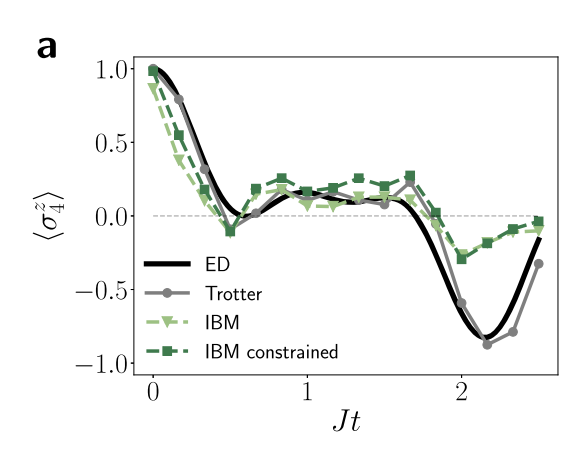

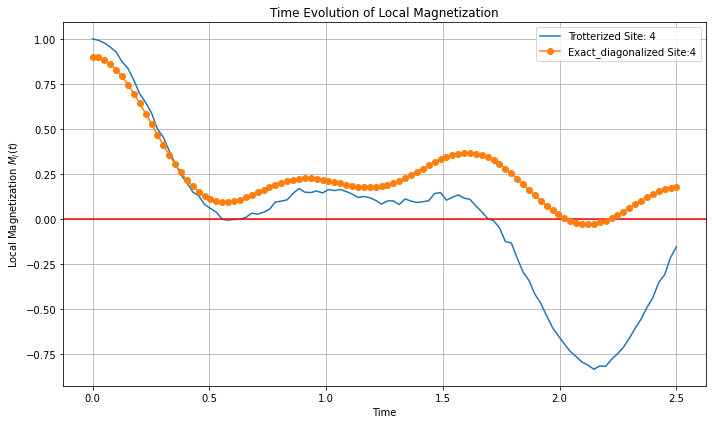

In [315]:
N_qubit = 6
Site=4
time=2.5
 
fig, ax = plt.subplots(figsize=(10, 6))
plot_localization(df, Site, ax)
plot_expectation_exact_diagonalization( N_qubit, Site, time, ax, Matrix, n_shots)
plt.tight_layout()
plt.show()

<font size="3">**Local magnetization at node 6**</font>

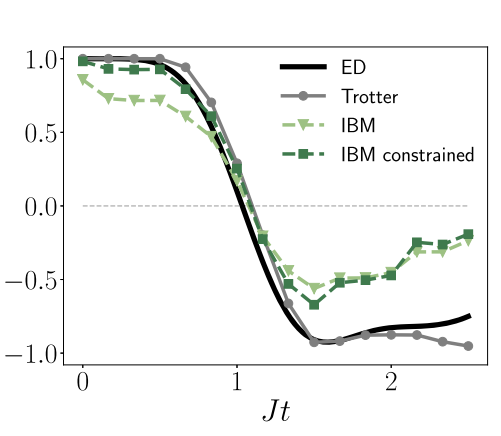

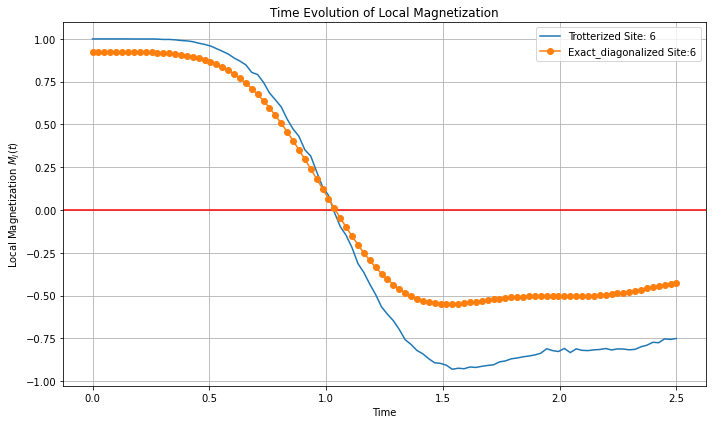

In [316]:
Site=6
 
fig, ax = plt.subplots(figsize=(10, 6))
plot_localization(df, Site, ax)
plot_expectation_exact_diagonalization( N_qubit, Site, time, ax, Matrix, n_shots)
plt.tight_layout()
plt.show()

<font size="3">**local magnetisations for N qubit=6**</font>

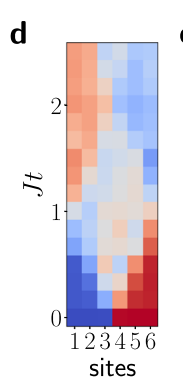


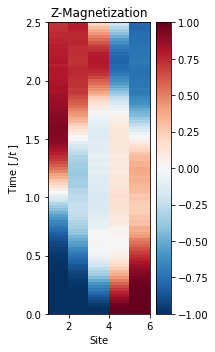

In [260]:
show_pcolor_mesh(df)

<font size="3">**Local magnetization at node 6 over JT=10**</font>
 
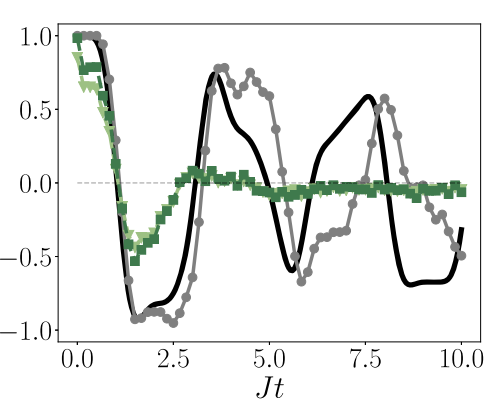


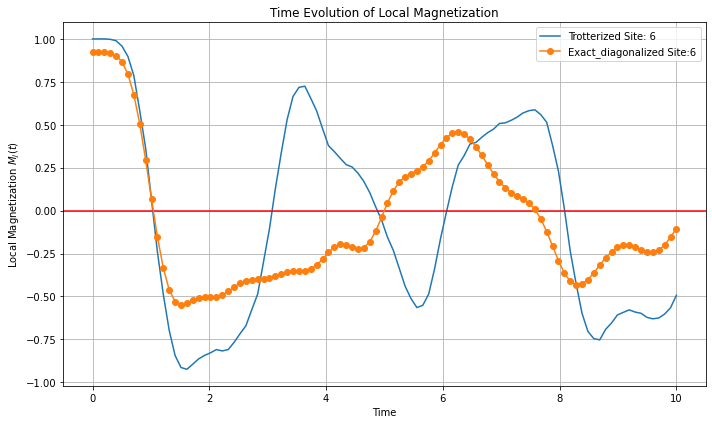

In [263]:
t=10
n_shots=100
t_values = np.linspace(0, t , num=n_shots) 
Site=6
df=create_assoc_df(t_values)

 
fig, ax = plt.subplots(figsize=(10, 6))
plot_localization(df, Site, ax)
plot_expectation_exact_diagonalization( N_qubit, Site, t, ax, Matrix, n_shots)
plt.tight_layout()
plt.show() 

<font size="3">local magnetisations for N qubit=8</font>
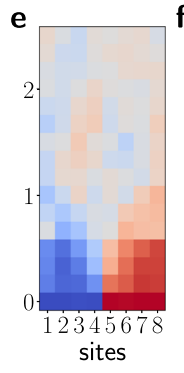

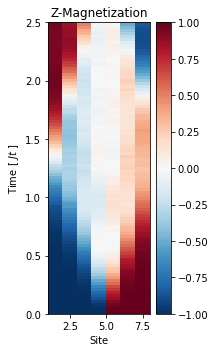

In [319]:
N_qubit=8
t_values = np.linspace(0, 2.5e5 , num=100) 
df=create_assoc_df(t_values,N_qubit=N_qubit,h=np.random.rand(N_qubit)*0)
show_pcolor_mesh(df)

<font size="3">**local magnetisations for N qubit=10**</font>
 

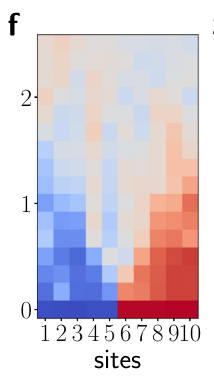

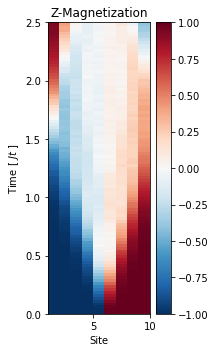

In [8]:
N_qubit=10
t_values = np.linspace(0, 2.5 , num=100) 
df=create_assoc_df(t_values,N_qubit=N_qubit,h=np.random.rand(N_qubit)*0)
show_pcolor_mesh(df)

<font size="3">**N_half over different h values**</font>
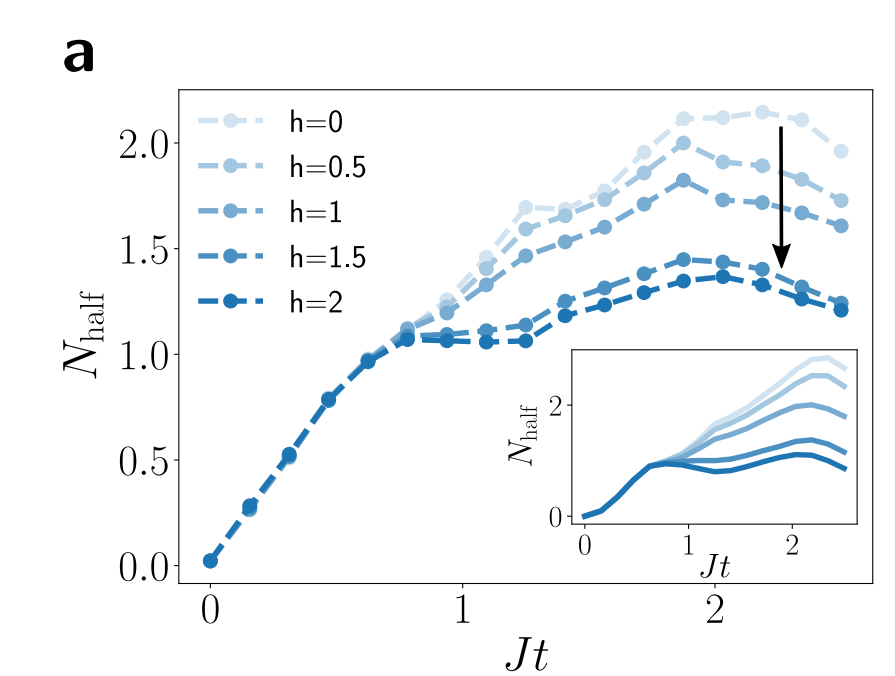

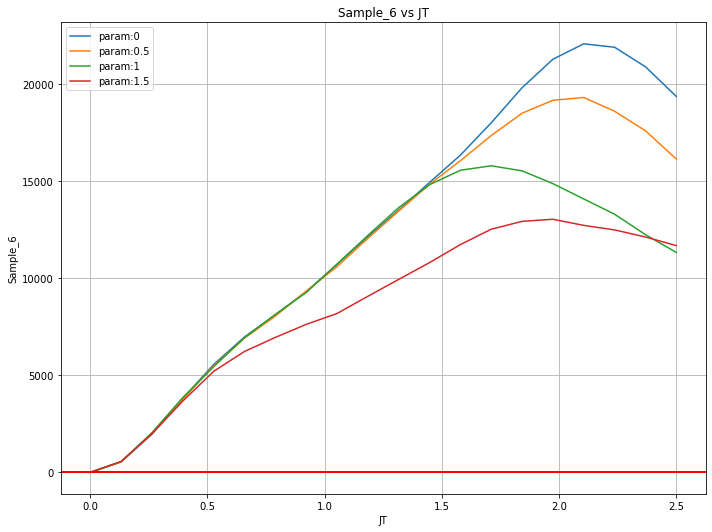

In [268]:
fig, ax = plt.subplots(figsize=(10, 7.5))
t_values = np.linspace(0, 2.5 , num=20) 
hparams=[0,0.5,1,1.5]
for h in hparams:
    df = create_assoc_df(t_values, h=np.random.uniform(-h, h, N_qubit))
    plot_N_half(ax, df, N_qubit, h)

plt.show()

<font size="3">**N_half over different U values**</font>

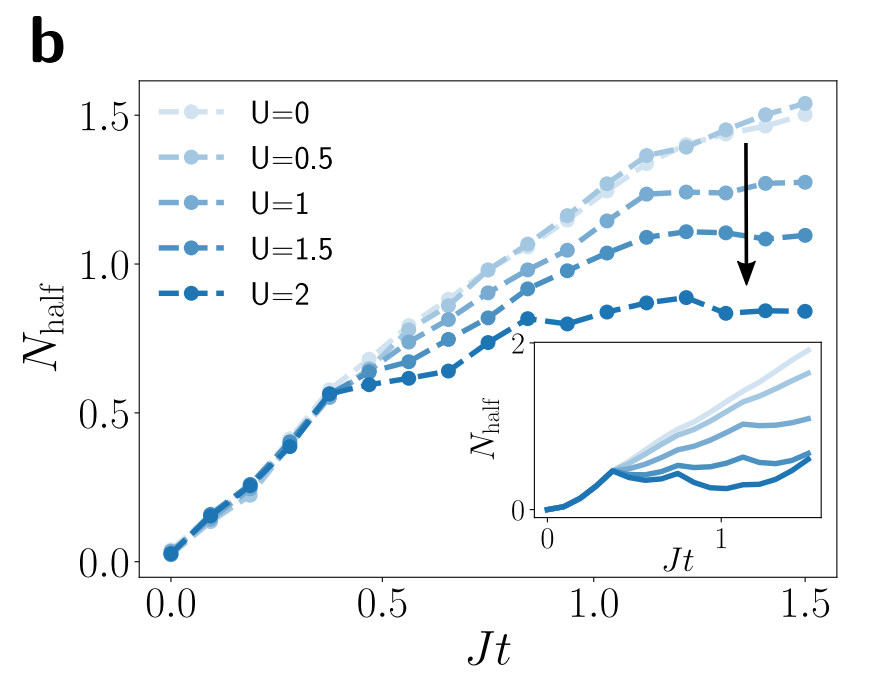


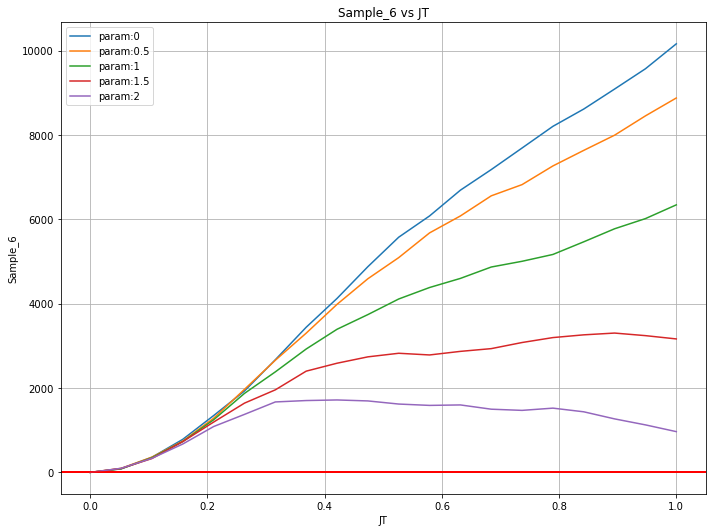

In [245]:
fig, ax = plt.subplots(figsize=(10, 7.5))
t_values = np.linspace(0, 1 , num=20) 
Uparams=[0,0.5,1,1.5,2]
for u in Uparams:
    df = create_assoc_df(t_values,U=u)
    plot_N_half(ax, df, N_qubit, u)

plt.show()

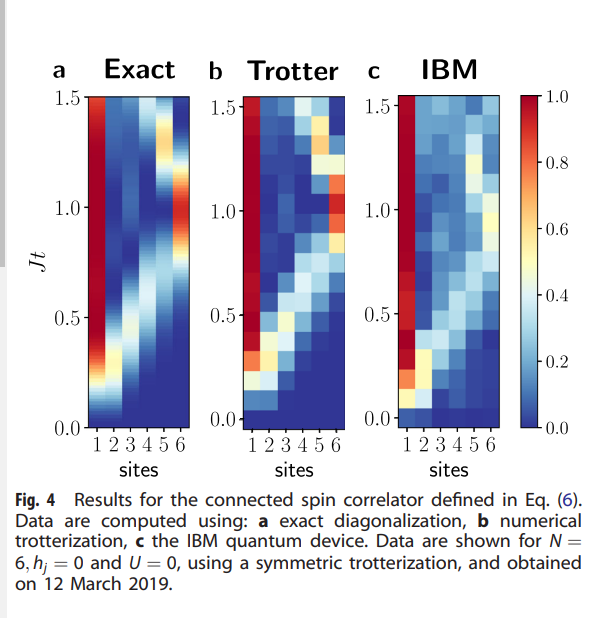
Note difference might be a result of " using a symmetric trotterization"

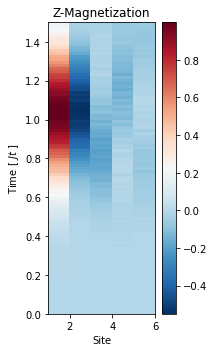

In [197]:
t_values = np.linspace(0, 1.5 , num=100) # Note: domain wall initialization reversed manually
df=create_assoc_df(t_values)
show_pcolor_mesh(df,Type="Cj")

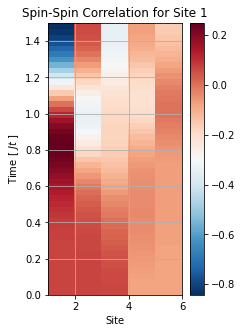

In [321]:
plot_expectation_exact_diagonalization(N_qubit, 1, 1.5, ax, Matrix, 50,Plot_expectation = "Correlator")

